# Generators

In [13]:
import numpy as np
import matplotlib.pyplot as plt

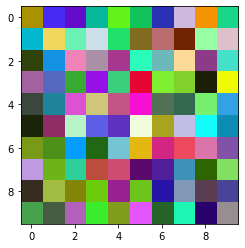

In [14]:
plt.imshow(np.random.random((10,10,3)))

In [15]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-guj2_csu
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-guj2_csu
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp37-none-any.whl size=7332 sha256=b2567c360d09c95d1025fa56345373b5055069bb76b85d0c3705eca30926e103
  Stored in directory: /tmp/pip-ephem-wheel-cache-mv9yciud/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR


In [16]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import pylab
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.utils

In [17]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [18]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

In [19]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [20]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [21]:
latent_size = 64
hidden_size = 256
image_size = 784
batch_size = 32

In [22]:
%%capture
#MNIST
# train_set = datasets.MNIST('./data', train=True, download=True)
# test_set = datasets.MNIST('./data', train=False, download=True)

#KMNIST
#train_set = datasets.KMNIST('./data', train=True, download=True)
#test_set = datasets.KMNIST('./data', train=False, download=True)

#Fashion MNIST
train_set = datasets.FashionMNIST('./data', train=True, download=True)
test_set = datasets.FashionMNIST('./data', train=False, download=True)

In [23]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5
X_test = (X_test - 0.5)/0.5

In [24]:
n = 7

index = np.where(Y == n)
X = X[index]
index = np.where(Y_test == n)
X_test = X_test[index]

In [25]:
X.shape,Y.shape,X_test.shape,Y_test.shape

((6000, 1, 28, 28), (60000,), (1000, 1, 28, 28), (10000,))

In [26]:
###################################################

In [27]:
X = GPU_data(X)
X_test = GPU_data(X_test)

# Y = GPU_data(Y)
# Y_test = GPU_data(Y_test)

In [28]:
def get_batch(mode):
    b = batch_size
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:,:,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:,:,:]
        y = Y_test[r:r+b]
    return x,y

In [29]:
x,y = get_batch('train')

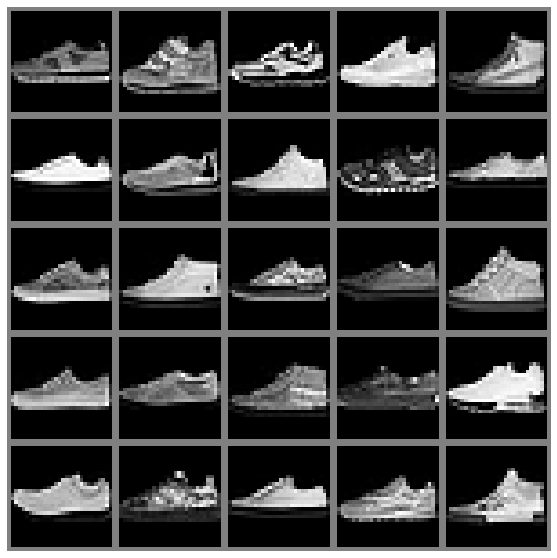

In [31]:
montage_plot(x[0:25,0,:,:].detach().cpu().numpy())

In [32]:
X = X.view(-1,784)

def get_batch(mode):
    b = batch_size
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [33]:
# Discriminator
def D(x,w):
    x = linear(x,w[0])
    x = leaky_relu(x,0.2)
    x = linear(x,w[1])
    x = leaky_relu(x,0.2)
    x = linear(x,w[2])
    x = torch.sigmoid(x)
    return x               

In [34]:
# Generator
def G(x,w):
    x = linear(x,w[3])
    x = relu(x,0.2)
    x = linear(x,w[4])
    x = relu(x,0.2)
    x = linear(x,w[5])
    x = torch.tanh(x)
    return x       

In [35]:
def backprop(model):
    if model == 'D':
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

    elif model ==  'G':
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

In [36]:
# Discriminator
w0 = GPU(randn_trunc((hidden_size,image_size)))
w1 = GPU(randn_trunc((hidden_size,hidden_size)))
w2 = GPU(randn_trunc((1,hidden_size)))

# Generator
w3 = GPU(randn_trunc((hidden_size,latent_size)))
w4 = GPU(randn_trunc((hidden_size,hidden_size)))
w5 = GPU(randn_trunc((image_size,hidden_size )))

w = [w0,w1,w2,w3,w4,w5]

In [37]:
d_optimizer = torch.optim.Adam(w[0:3], lr=0.0002)
g_optimizer = torch.optim.Adam(w[3:], lr=0.0002)

real_labels = Variable(torch.ones(batch_size, 1).cuda())
fake_labels = Variable(torch.zeros(batch_size, 1).cuda())

In [38]:
num_epochs = 100 
batches = X.shape[0]//batch_size
steps = num_epochs*batches

In [39]:
z1 = Variable(torch.randn(steps,batch_size,latent_size).cuda())
z2 = Variable(torch.randn(steps,batch_size,latent_size).cuda())

In [40]:
for i in range(steps):
        
    images,y = get_batch('train')
        
    d_loss = binary_cross_entropy(D(images,w), real_labels) + binary_cross_entropy(D(G(z1[i],w),w), fake_labels)
    backprop('D')
    
    g_loss = binary_cross_entropy(D(G(z2[i],w),w), real_labels)
    backprop('G')

    
    if i % 5000 == 0:
        out = G(z1[np.random.randint(steps)],w)
        montage_plot(out.view(batch_size,1,28,28).detach().cpu().numpy()[0:25,0,:,:])

Output hidden; open in https://colab.research.google.com to view.

#Convolutional Transpose

In [41]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-nrozr0pv
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-nrozr0pv
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp37-none-any.whl size=7332 sha256=d3c6503f7aa6c25d68aa405540d8051428531065b5a22a66adec5e066329b320
  Stored in directory: /tmp/pip-ephem-wheel-cache-_7at1ru0/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR


In [42]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import pylab
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.utils

In [43]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [44]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

In [45]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [46]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [47]:
latent_size = 64
hidden_size = 256
image_size = 784
batch_size = 32

In [48]:
%%capture
#MNIST
# train_set = datasets.MNIST('./data', train=True, download=True)
# test_set = datasets.MNIST('./data', train=False, download=True)

#KMNIST
#train_set = datasets.KMNIST('./data', train=True, download=True)
#test_set = datasets.KMNIST('./data', train=False, download=True)

#Fashion MNIST
train_set = datasets.FashionMNIST('./data', train=True, download=True)
test_set = datasets.FashionMNIST('./data', train=False, download=True)

In [49]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5
X_test = (X_test - 0.5)/0.5

In [50]:
n = 7

index = np.where(Y == n)
X = X[index]
index = np.where(Y_test == n)
X_test = X_test[index]

In [51]:
X.shape,Y.shape,X_test.shape,Y_test.shape

((6000, 1, 28, 28), (60000,), (1000, 1, 28, 28), (10000,))

In [52]:
###################################################

In [53]:
X = GPU_data(X)
X_test = GPU_data(X_test)
Y = GPU_data(Y)
Y_test = GPU_data(Y_test)

In [54]:
def get_batch(mode):
    b = batch_size
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:,:,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:,:,:]
        y = Y_test[r:r+b]
    return x,y

In [55]:
x,y = get_batch('train')

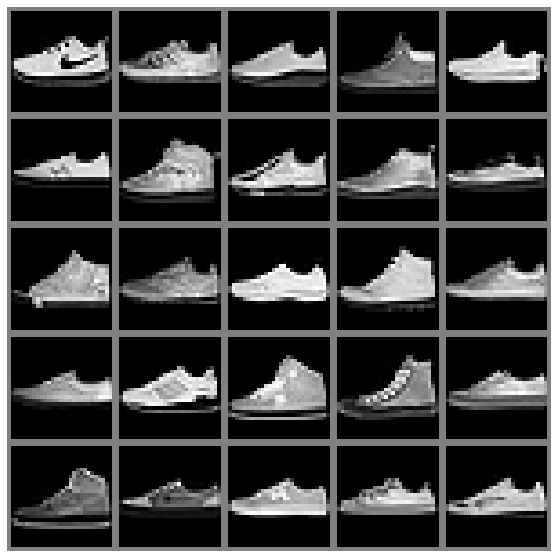

In [56]:
montage_plot(x[0:25,0,:,:].detach().cpu().numpy())

In [57]:
def backprop(model):
    if model == 'd':
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
    elif model ==  'g':
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

In [58]:
#D
w0 = GPU(randn_trunc((64,1,4,4)))
w1 = GPU(randn_trunc((128,64,4,4)))
w2 = GPU(randn_trunc((1,6272)))
#G
w3 = GPU(randn_trunc((6272,64)))
w4 = GPU(randn_trunc((128,64,4,4)))
w5 = GPU(randn_trunc((64,1,4,4)))

w = [w0,w1,w2,w3,w4,w5]

In [59]:
def D(x,w):
    x = relu(conv2d(x,w[0], stride=(2, 2), padding=(1, 1)))
    x = relu(conv2d(x,w[1], stride=(2, 2), padding=(1, 1)))
    x = x.view(x.size(0), 6272)
    x = linear(x,w[2])
    x = torch.sigmoid(x)
    return x

In [60]:
def G(x,w):
    x = linear(x,w[3])
    x = x.view(x.size(0), 128, 7, 7)
    x = relu(conv_transpose2d(x,w[4], stride=(2, 2), padding=(1, 1)))
    x = torch.tanh(conv_transpose2d(x,w[5], stride=(2, 2), padding=(1, 1)))
    return x

In [61]:
d_optimizer = torch.optim.Adam(w[0:3], lr=0.0002)
g_optimizer = torch.optim.Adam(w[3:], lr=0.0002)

real_labels = Variable(torch.ones(batch_size, 1).cuda())
fake_labels = Variable(torch.zeros(batch_size, 1).cuda())

In [62]:
num_epochs = 100 
batches = X.shape[0]//batch_size
steps = num_epochs*batches

In [63]:
z1 = Variable(torch.randn(steps,batch_size,latent_size).cuda())
z2 = Variable(torch.randn(steps,batch_size,latent_size).cuda())

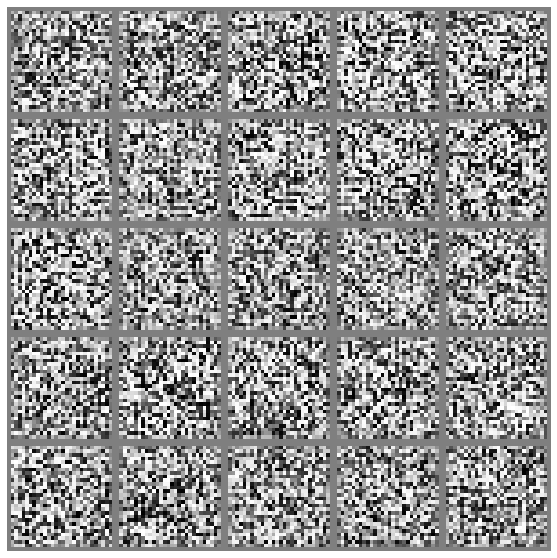

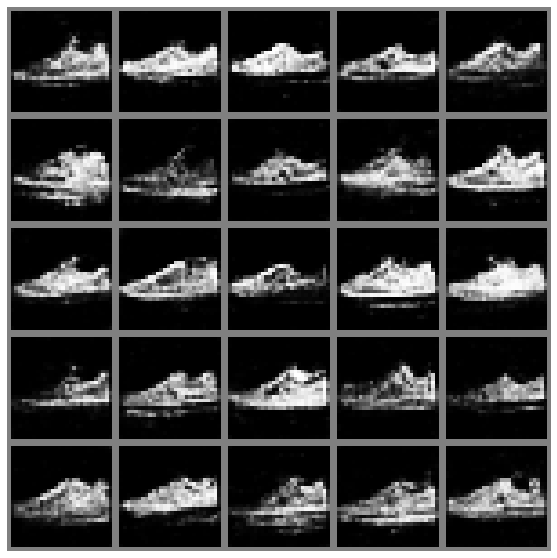

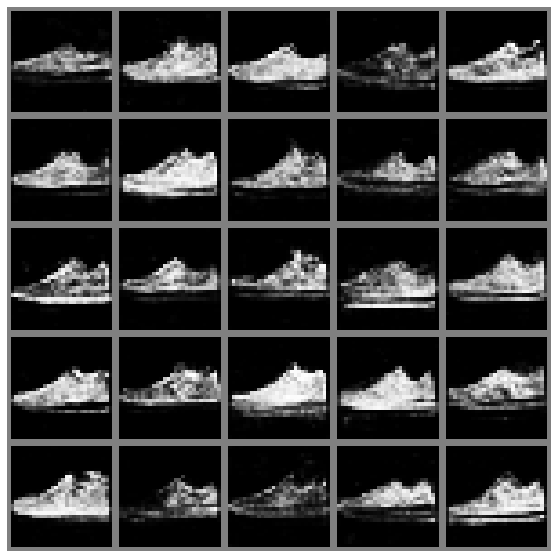

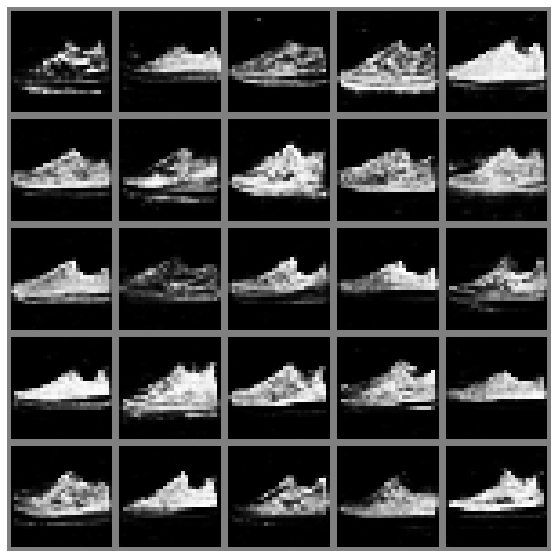

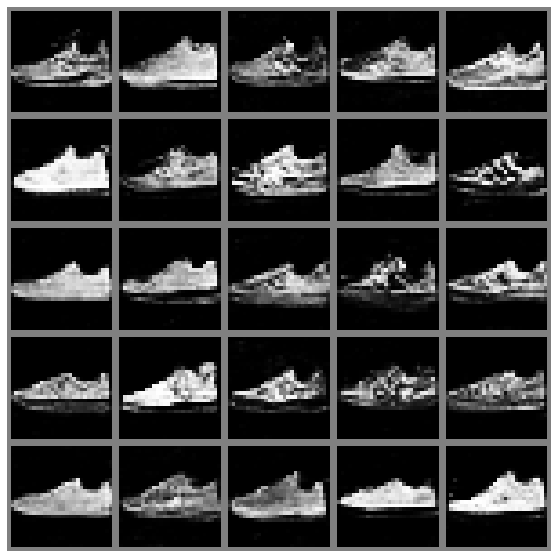

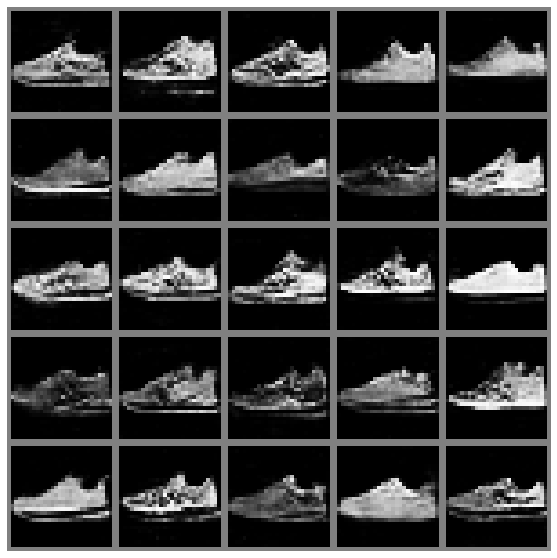

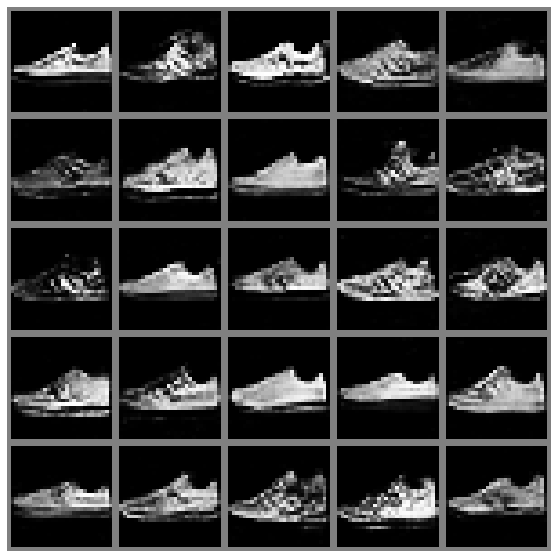

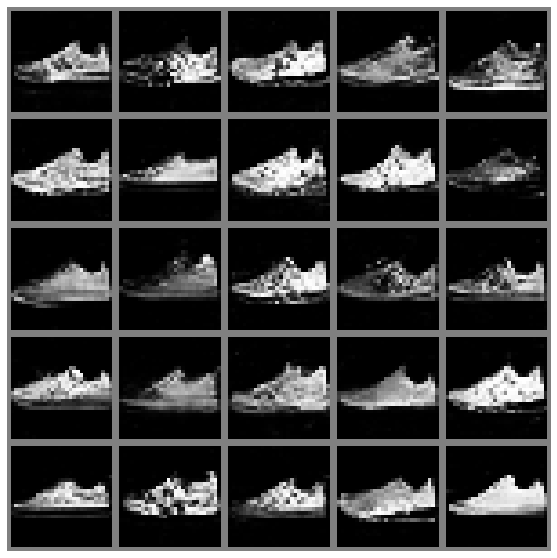

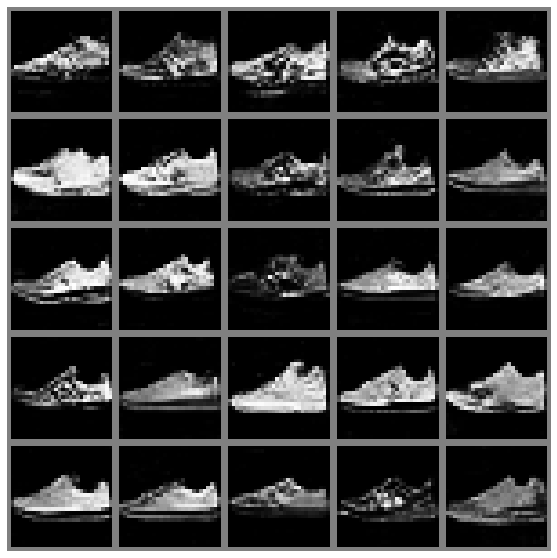

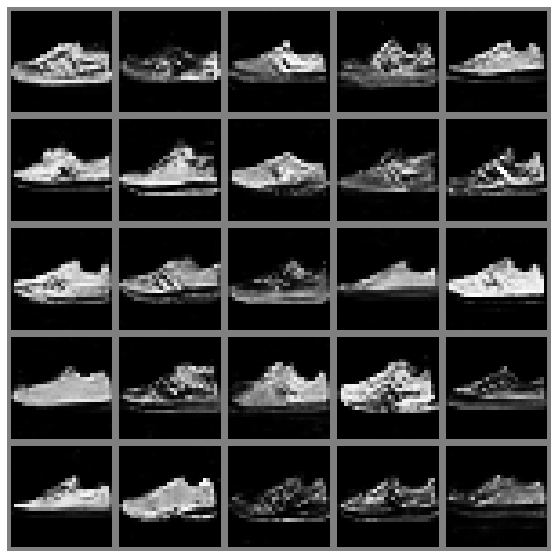

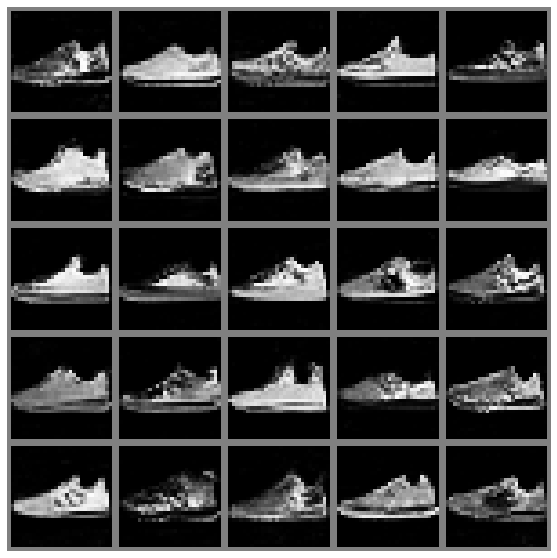

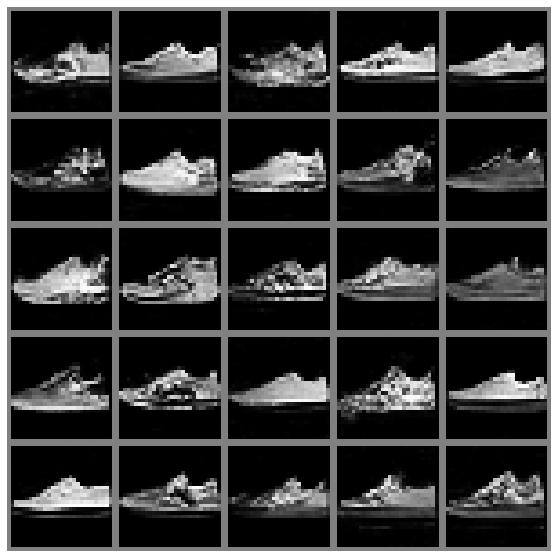

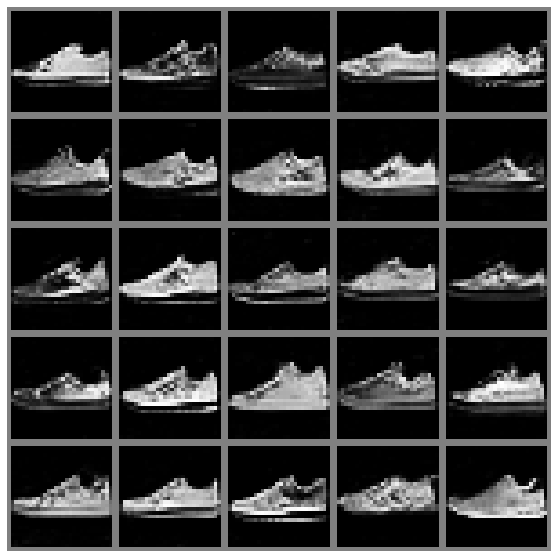

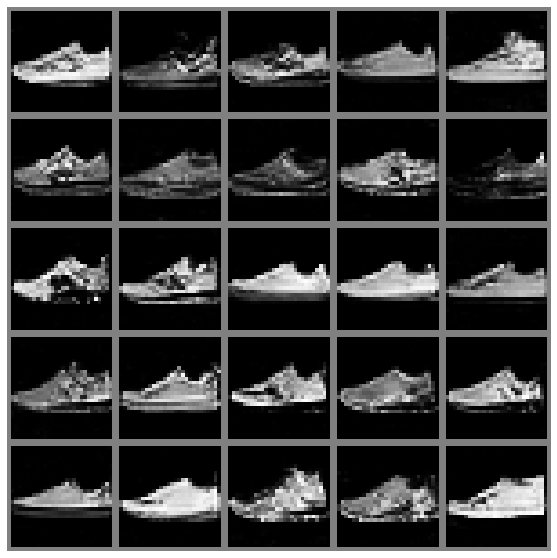

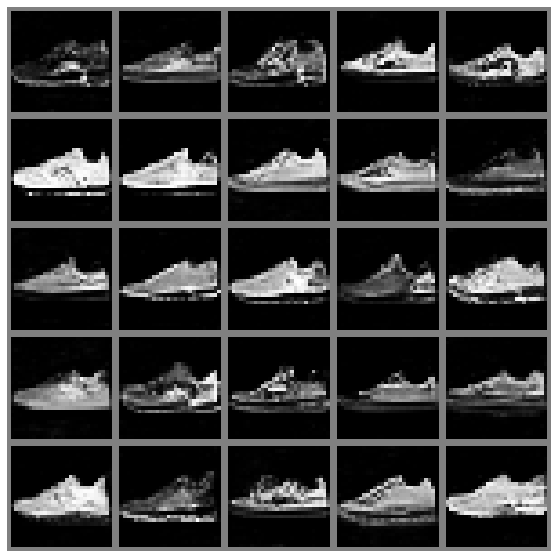

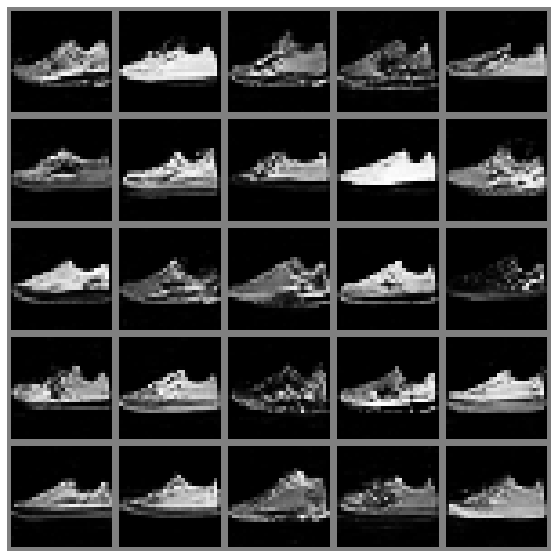

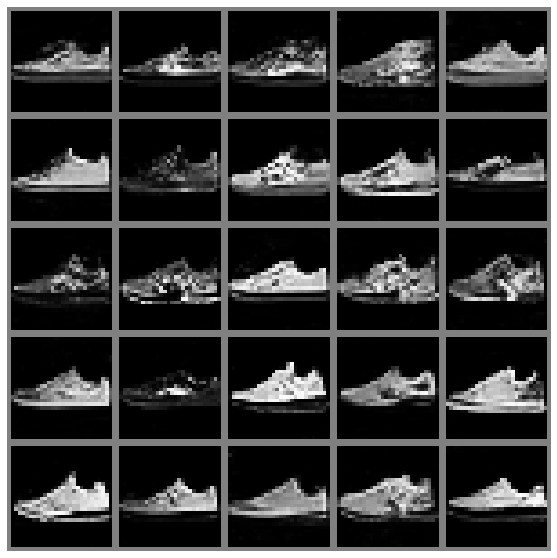

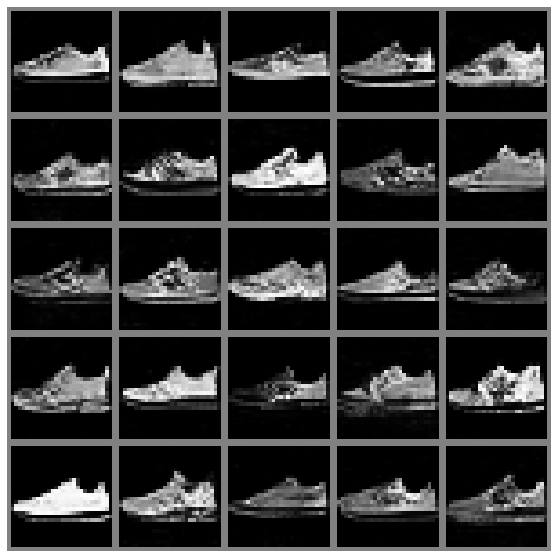

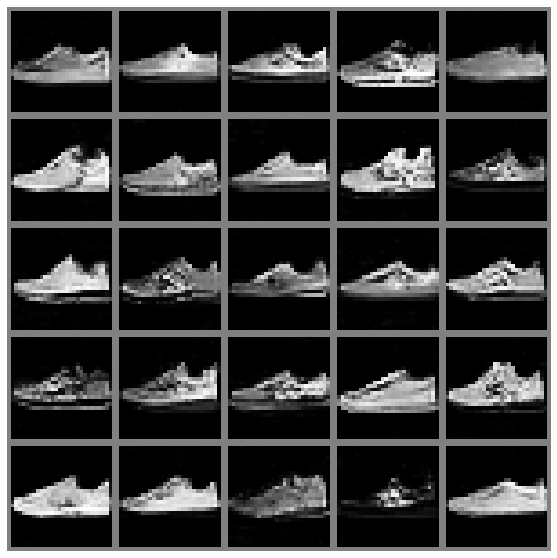

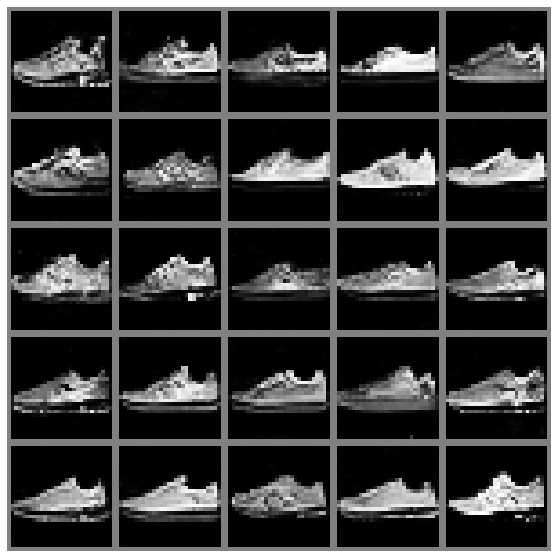

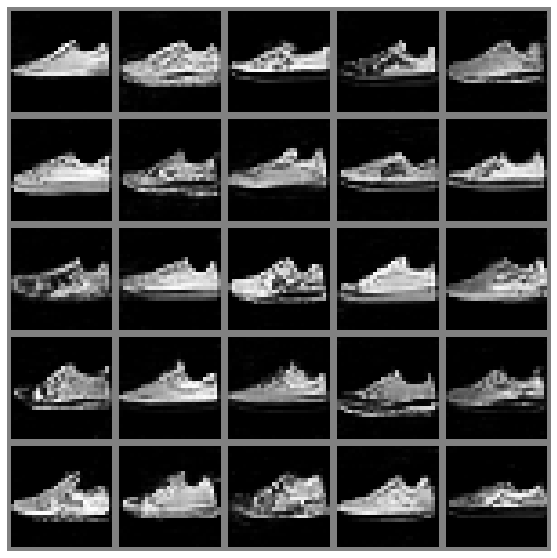

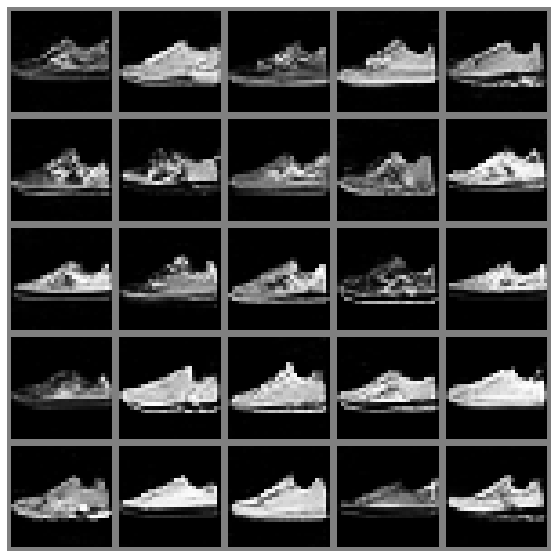

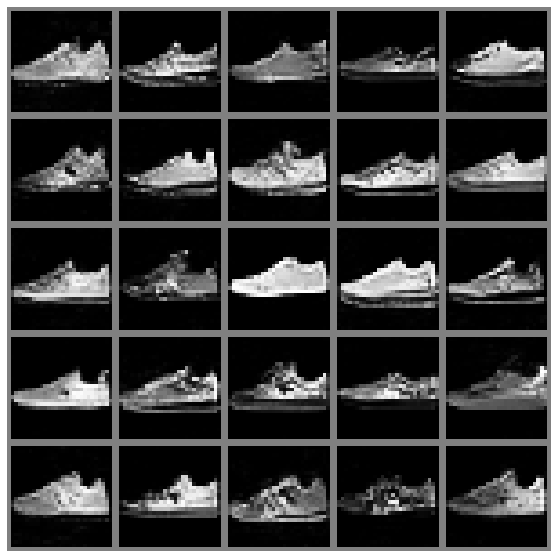

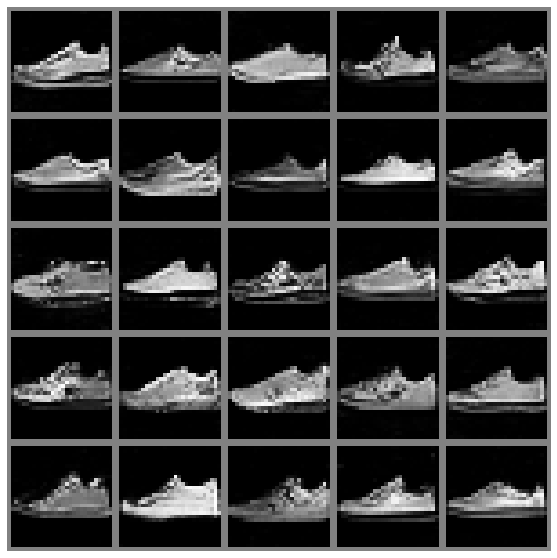

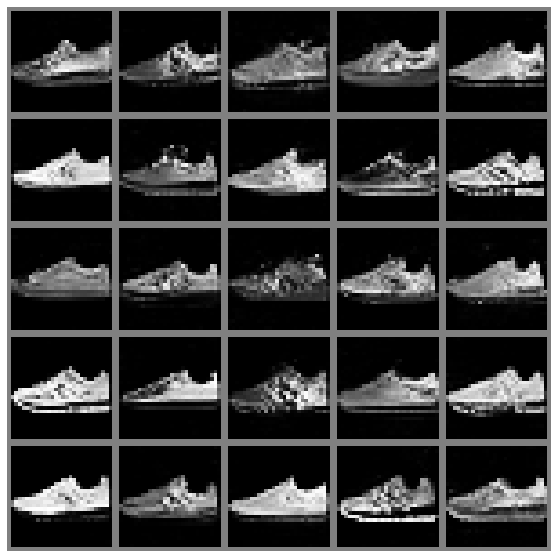

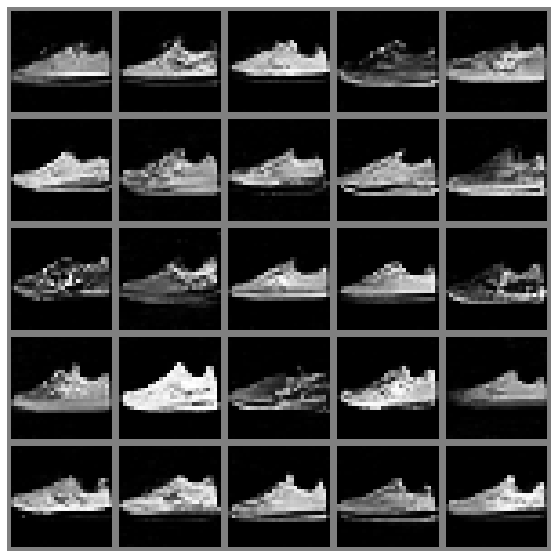

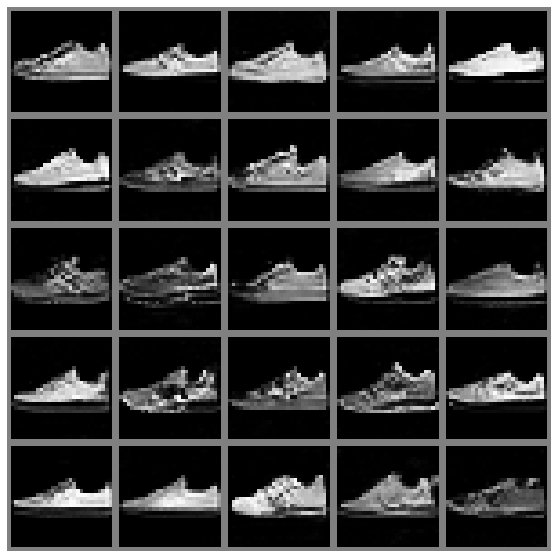

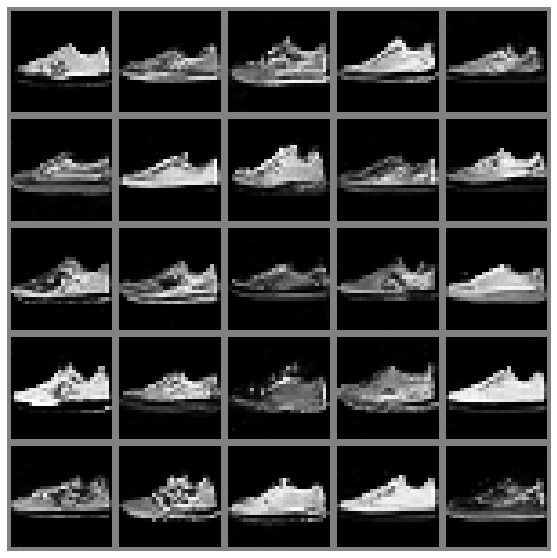

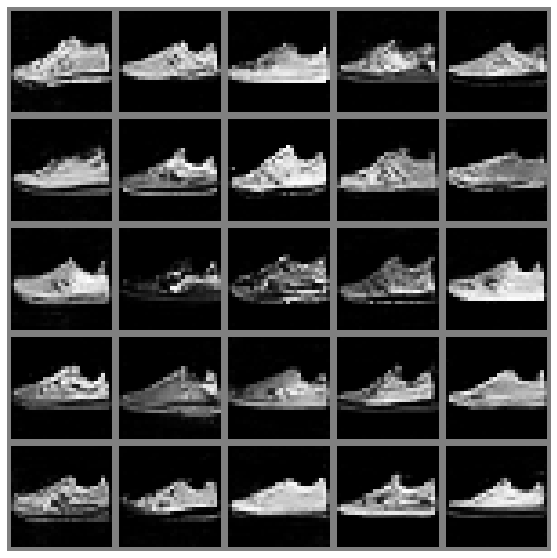

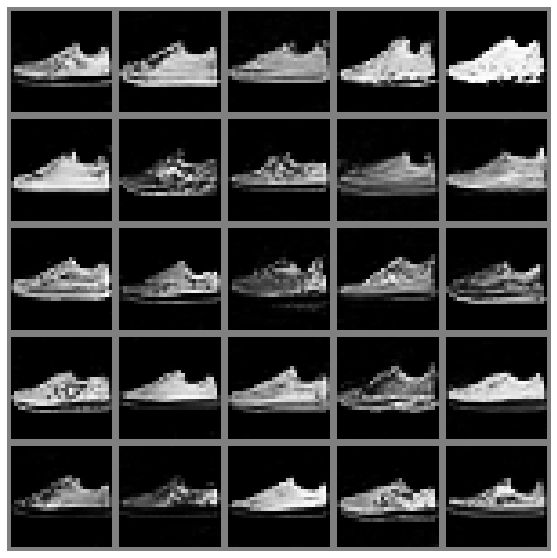

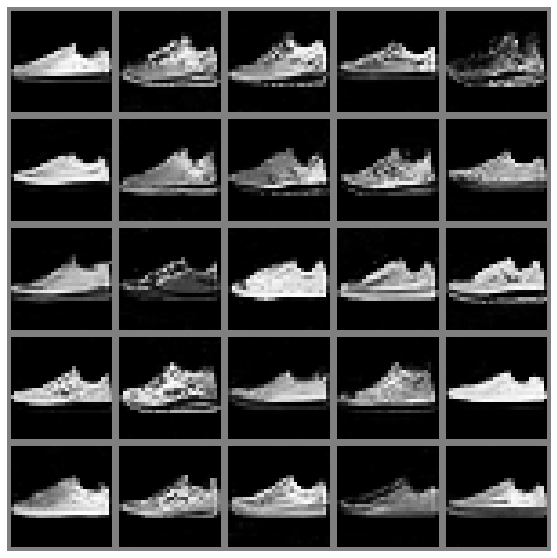

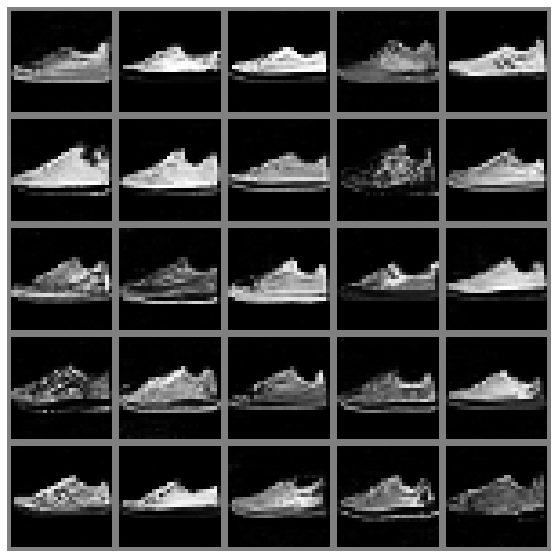

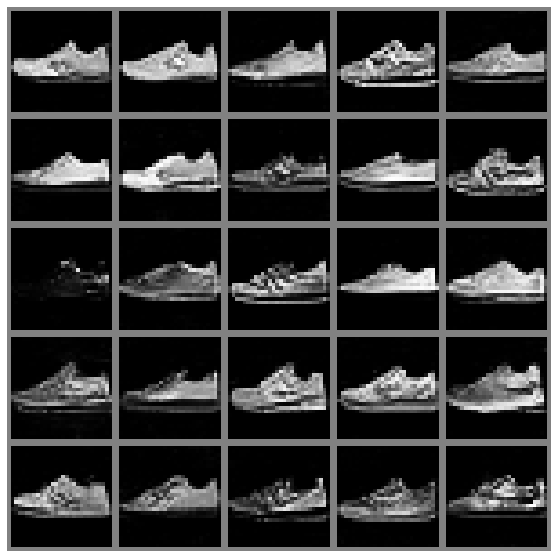

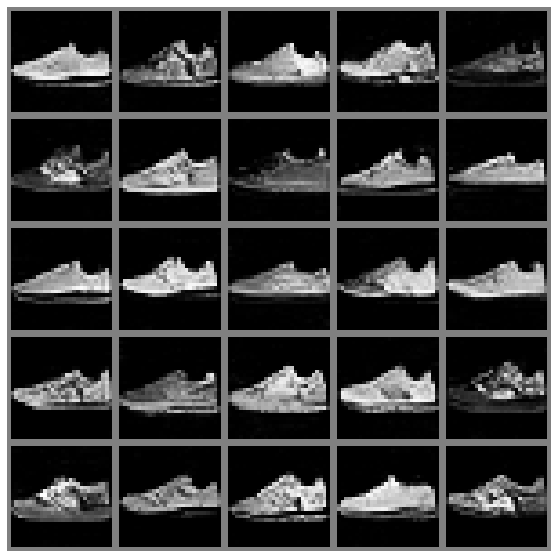

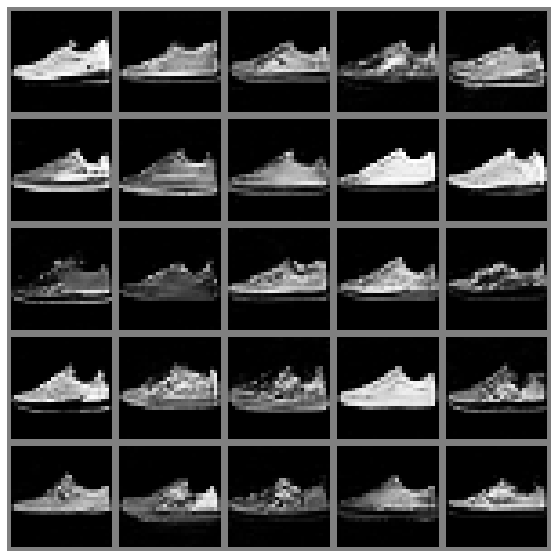

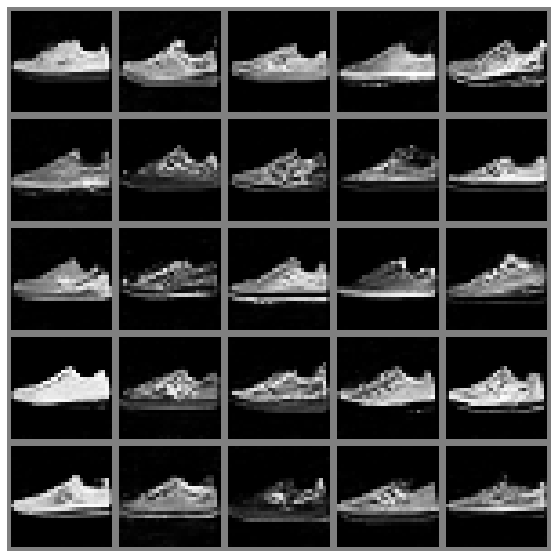

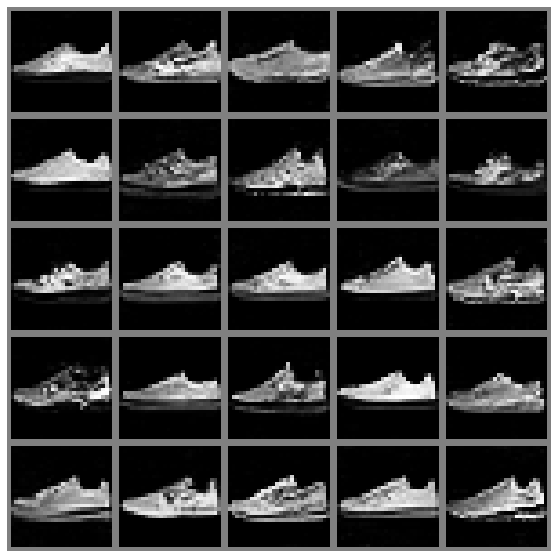

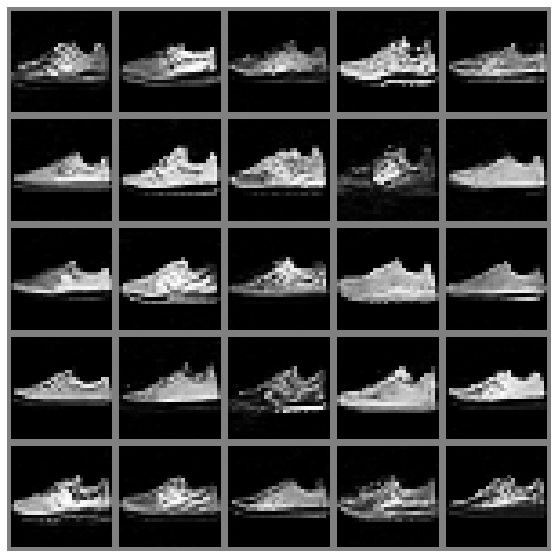

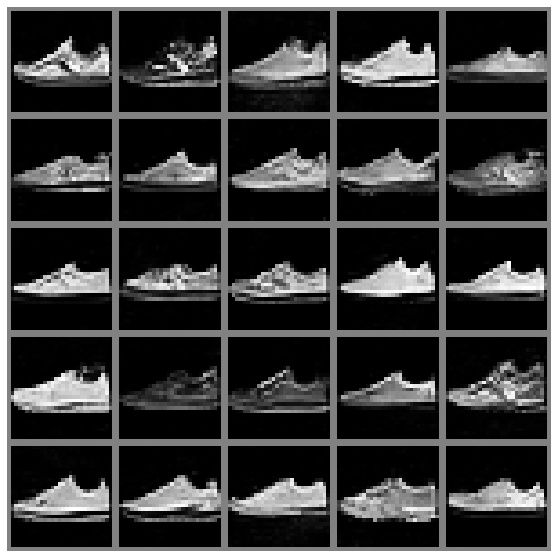

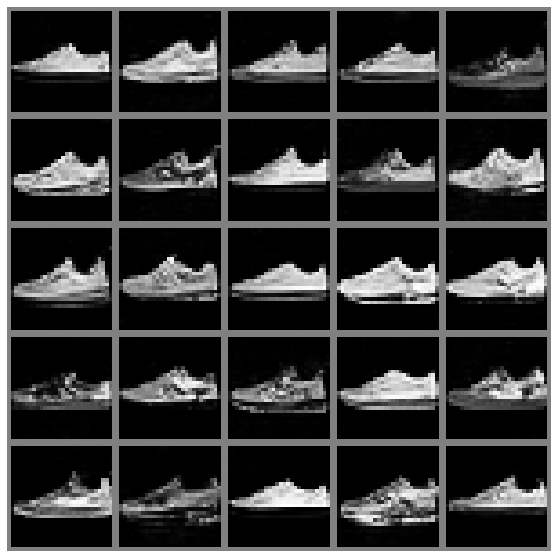

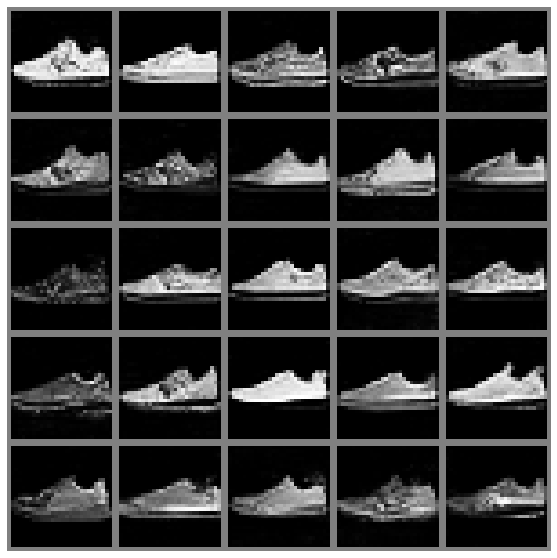

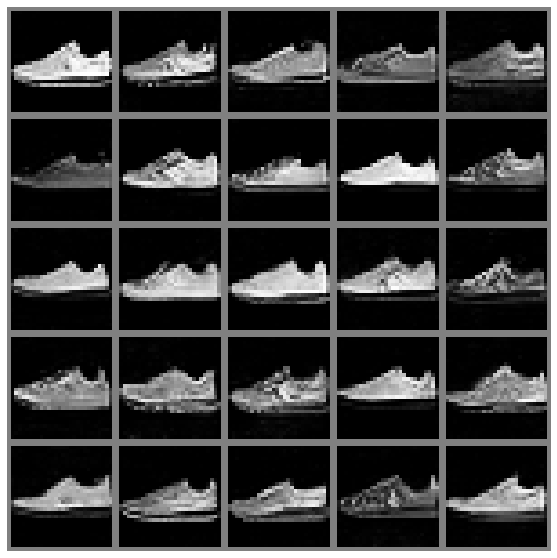

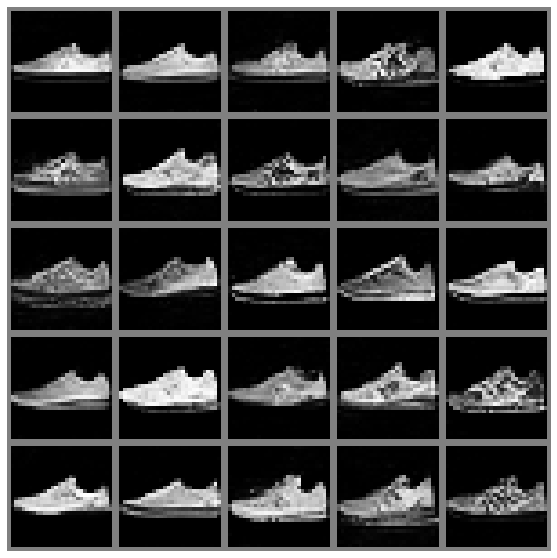

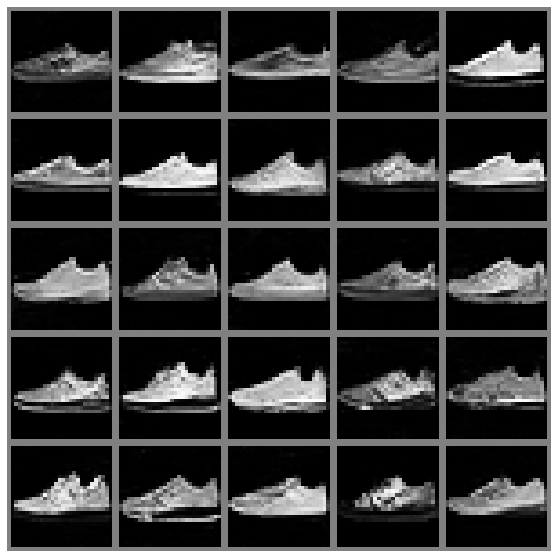

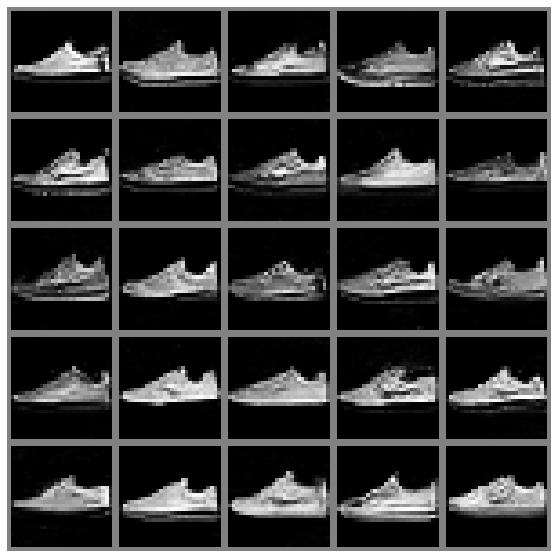

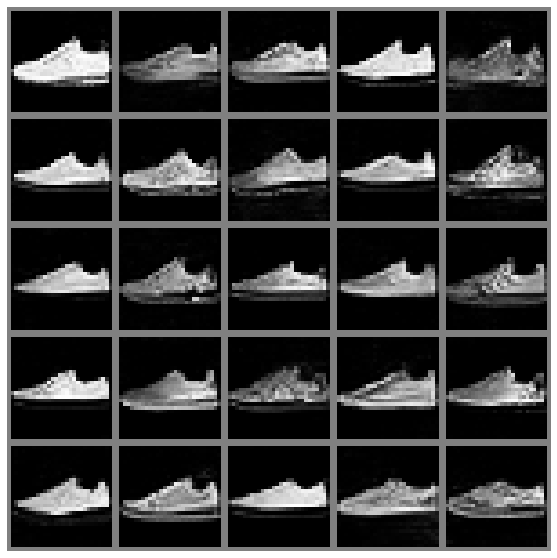

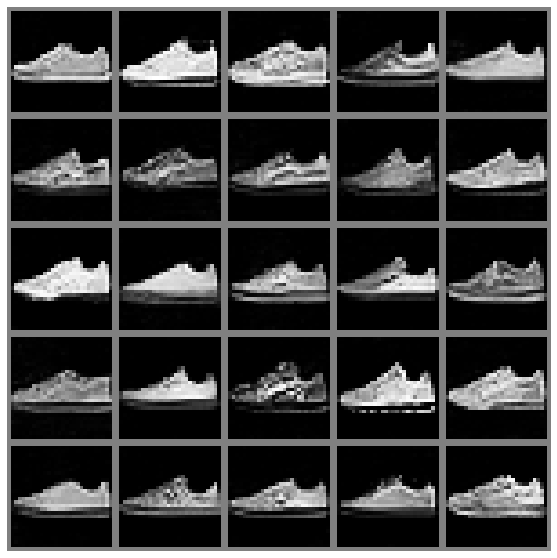

In [64]:
for i in range(steps):
        
    images,y = get_batch('train')
        
    d_loss = binary_cross_entropy(D(images,w), real_labels) + binary_cross_entropy(D(G(z1[i],w),w), fake_labels)
    backprop('d')
    
    g_loss = binary_cross_entropy(D(G(z2[i],w),w), real_labels)
    backprop('g')

    
    if i % 5000 == 0:
        out = G(z1[np.random.randint(steps)],w)
        montage_plot(out.view(batch_size,1,28,28).detach().cpu().numpy()[0:25,0,:,:])